<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Centro_Universitario_del_Guadalajara_Logo.png/640px-Centro_Universitario_del_Guadalajara_Logo.png" alt="Drawing" style="width: 600px;"/>
</center>
    
<center> <span style="color:DarkBlue">  Tema 12: Clustering KMeans, Implementación con Scikit-Learn</span>  </center>
<center> <span style="color:Blue"> M. en C. Iván A. Toledano Juárez </span>  </center>

# Introducción a K-Means

`K-Means` es un algoritmo de *clustering* no supervisado. Su objetivo es agrupar observaciones en $K$ clústers, de tal forma que los puntos dentro del mismo clúster sean "parecidos" entre sí y "distintos" de los puntos en otros clústers.

La idea central es minimizar la distancia (con alguna métrica) entre cada punto y el centro de su clúster. A ese centro se le llama **centroide**.

El algoritmo clásico de K-Means sigue estos pasos:

1. Elegimos $K$, el número de clústers.
2. Inicializamos $K$ centroides (por ejemplo, de manera aleatoria).
3. Repetimos hasta converger:
   - **Asignación:** cada punto se asigna al centroide más cercano.
     
     Matemáticamente, para cada punto $x_i$ buscamos el índice $c_i$ tal que
     \begin{equation}
     c_i = \arg \min_{k \in \{1,\dots,K\}} \| x_i - \mu_k \|^2
     \end{equation}
     donde $\mu_k$ es el centroide del clúster $k$.
   
   - **Actualización:** cada centroide se actualiza como el promedio de todos los puntos que le fueron asignados:
     \begin{equation}
     \mu_k = \frac{1}{N_k} \sum_{i : c_i = k} x_i
     \end{equation}
     donde $N_k$ es el número de puntos asignados al clúster $k$.

El criterio que K-Means intenta minimizar es la **suma de los errores cuadrados dentro del clúster**, conocida como *inertia* en `scikit-learn`:
\begin{equation}
\text{Inertia} = \sum_{k=1}^{K} \sum_{i : c_i = k} \| x_i - \mu_k \|^2
\end{equation}

Observaciones importantes:
- K-Means asume clústers más o menos esféricos y de tamaño similar.
- Necesitamos decidir $K$ antes de entrenar.
- Es sensible a la escala de las variables y a valores atípicos (*outliers*).

En este notebook:
- Vamos a generar datos ficticios tridimensionales (3 variables numéricas).
- Vamos a ajustar un modelo de K-Means con `scikit-learn`.
- Vamos a visualizar los resultados en 3D.
- Vamos a estudiar cómo elegir $K$ usando:
  - el método del codo (*elbow method*),
  - el puntaje de silueta (*silhouette score*).
- Finalmente, vamos a animar las iteraciones del algoritmo para ver cómo se mueven los centroides.


## Generación y visualización de datos sintéticos en 3D

Para poder ilustrar K-Means sin usar datos reales, vamos a simular datos en 3 dimensiones $(x, y, z)$ que provienen de varios grupos bien separados en el espacio.

La ventaja de datos sintéticos es que:
- sabemos cuántos "grupos verdaderos" hay,
- podemos controlar la dispersión de cada grupo.

Vamos a:
1. Generar 3 nubes de puntos en 3D con medias diferentes.
2. Combinar todas las nubes en un solo `DataFrame`.
3. Visualizar en 3D con `matplotlib`.

Esto nos va a ayudar a **ver** por qué K-Means puede funcionar bien: si los grupos son aproximadamente esféricos y separados, el algoritmo debería recuperarlos.


In [20]:
# Importación de librerías 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
# Generación de datos ficticios

# Centroide "real" del grupo 1
mean1 = [0, 0, 0]
cov1 = [[0.6, 0.0, 0.0],
        [0.0, 0.6, 0.0],
        [0.0, 0.0, 0.6]]
cluster1 = np.random.multivariate_normal(mean1, cov1, size=150)

# Centroide "real" del grupo 2
mean2 = [5, 5, 2]
cov2 = [[0.7, 0.0, 0.0],
        [0.0, 0.7, 0.0],
        [0.0, 0.0, 0.7]]
cluster2 = np.random.multivariate_normal(mean2, cov2, size=150)

# Centroide "real" del grupo 3
mean3 = [0, 6, 8]
cov3 = [[0.8, 0.0, 0.0],
        [0.0, 0.8, 0.0],
        [0.0, 0.0, 0.8]]
cluster3 = np.random.multivariate_normal(mean3, cov3, size=150)

# 2.3 Combinar en un solo arreglo
X = np.vstack([cluster1, cluster2, cluster3])

# También nos guardamos etiquetas "verdaderas" solo para visualizar,
# aunque K-Means NO las usa (es no supervisado).
true_labels = np.array([0]*150 + [1]*150 + [2]*150)

# 2.4 Pasar a DataFrame para inspección rápida
df = pd.DataFrame(X, columns=["x", "y", "z"])
df["true_cluster"] = true_labels
df.head()

,x,y,z,true_cluster
0,0.081251,-0.341803,-0.372800,0
1,0.030888,0.083823,-0.306959,0
2,-0.155693,-0.089462,-0.747711,0
3,0.863853,0.112829,-0.410522,0
4,-0.530832,-0.907721,0.318098,0


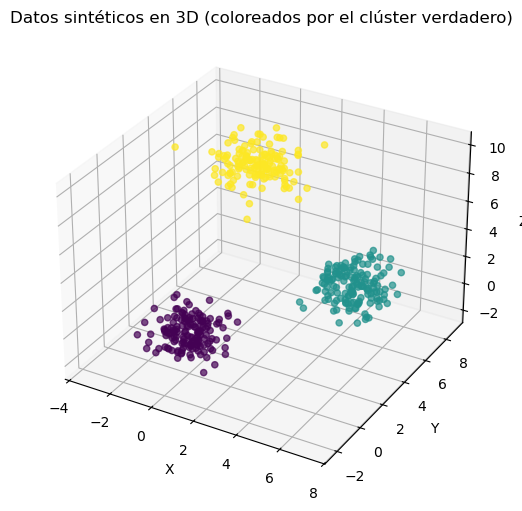

In [3]:
# Visualización inicial 3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df["x"], df["y"], df["z"],
    c=df["true_cluster"],
    alpha=0.7
)

ax.set_title("Datos sintéticos en 3D (coloreados por el clúster verdadero)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

## Implementación de modelo de K-Means con `scikit-learn`

Ahora vamos a aplicar K-Means sobre nuestros datos `X`.

Vamos a empezar suponiendo que sí sabemos que hay 3 clústers. Más adelante vamos a discutir cómo elegir $K$ cuando no lo sabemos.


In [5]:
# 1. Instanciar el modelo
k = 3
kmeans = KMeans(
    n_clusters=k,
    n_init=10,         # número de inicializaciones diferentes para evitar mínimos locales malos
    max_iter=300,      # máximo de iteraciones por inicialización
    random_state=42
)

# 2. Ajustar el modelo
kmeans.fit(X)

# 3. Obtener etiquetas asignadas por K-Means
kmeans_labels = kmeans.labels_

# 4. Obtener centroides estimados
centroids = kmeans.cluster_centers_

print("Centroides estimados (x, y, z):")
print(centroids)

# Agregamos las etiquetas de K-Means al DataFrame para graficar
df["kmeans_cluster"] = kmeans_labels
df.head()

Centroides estimados (x, y, z):
[[ 5.04633987  5.01216472  1.97697935]
 [-0.06989973  5.97047146  7.85929899]
 [ 0.01190062  0.05252697  0.03618616]]


,x,y,z,true_cluster,kmeans_cluster
0,0.081251,-0.341803,-0.372800,0,2
1,0.030888,0.083823,-0.306959,0,2
2,-0.155693,-0.089462,-0.747711,0,2
3,0.863853,0.112829,-0.410522,0,2
4,-0.530832,-0.907721,0.318098,0,2


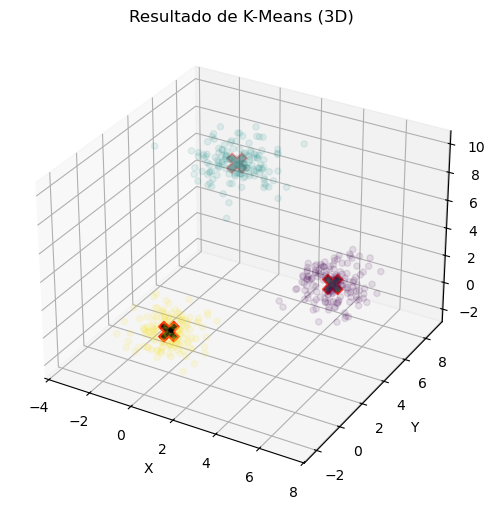

In [15]:
# Visualización 3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df["x"], df["y"], df["z"],
    c=df["kmeans_cluster"],
    alpha=0.1
)

# Dibujar los centroides en grande
ax.scatter(
    centroids[:,0],
    centroids[:,1],
    centroids[:,2],
    marker='X',
    s=200,
    edgecolor='red',
    color="black",
    linewidth=1.5
)

ax.set_title("Resultado de K-Means (3D)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

## Interpretación de resultados

Después de ajustar K-Means, tenemos:

- `labels_`: a cada punto le asigna un número de clúster $\{0,1,\dots,K-1\}$.
- `cluster_centers_`: coordenadas del centroide de cada clúster en el espacio de las variables originales.
- `inertia_`: la suma total de las distancias cuadráticas dentro de cada clúster.
  Este valor es exactamente la función objetivo que K-Means está minimizando:
  \begin{equation}
  \text{Inertia} = \sum_{k=1}^{K} \sum_{i : c_i = k} \| x_i - \mu_k \|^2
  \end{equation}

Podemos inspeccionar:
1. ¿Los centroides estimados son cercanos a los centros verdaderos que usamos para generar los datos?
2. ¿Qué tan bien separa los grupos?

## ¿Cuántos clústers elegir?

En la vida real no sabemos cuántos clústers hay. Existen varias heurísticas para elegir $K$. Veremos dos muy comunes:

### Método del codo (*Elbow method*)

La idea:
- Entrenamos K-Means para distintos valores de $K$ (por ejemplo $K=1,2,3,\dots,10$).
- Para cada $K$, registramos la `inertia_`.
- Graficamos `inertia_` contra $K$.
- Buscamos un "codo" en la gráfica: un punto donde agregar más clústers deja de reducir drásticamente la inercia.
  
Intuición: antes del codo, cada clúster adicional explica mucha variación extra; después del codo, las mejoras son marginales.

### Puntaje de silueta (*Silhouette score*)

El puntaje de silueta mide qué tan bien separado está un punto respecto a los clústers vecinos.

Para cada punto $i$:
- $a(i)$ = distancia promedio al resto de puntos de su propio clúster.
- $b(i)$ = distancia promedio al clúster vecino más cercano (el mejor clúster alternativo).
  
La silueta de $i$ es:
\begin{equation}
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
\end{equation}
y está entre $-1$ y $1$.

Interpretación:
- $s(i)$ cerca de 1: el punto está bien dentro de su clúster y lejos de los demás.
- $s(i)$ cerca de 0: el punto está en la frontera entre clústers.
- $s(i)$ negativo: probablemente está mal asignado.

Podemos:
- Calcular el `silhouette_score` promedio para cada $K$.
- Visualizar la distribución de siluetas por clúster usando herramientas como `yellowbrick`.


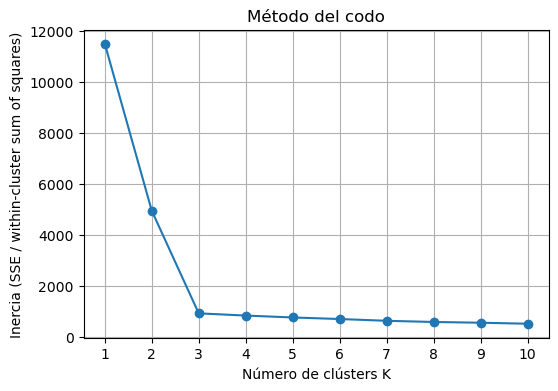

In [16]:
# Método del codo a mano

Ks = range(1, 11)
inertias = []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)  # suma de distancias cuadradas intra-cluster

plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker='o')
plt.xticks(Ks)
plt.xlabel("Número de clústers K")
plt.ylabel("Inercia (SSE / within-cluster sum of squares)")
plt.title("Método del codo")
plt.grid(True)
plt.show()

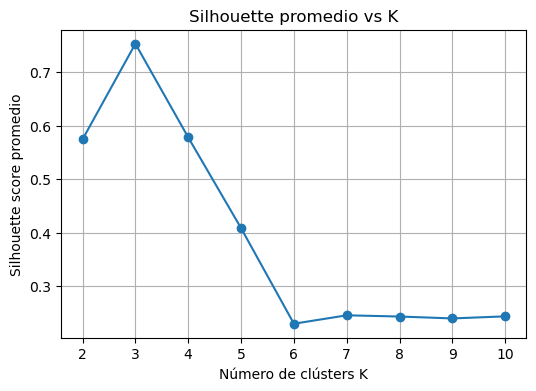

In [18]:
Ks = range(2, 11)  # la silueta no está definida para K=1
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(Ks, sil_scores, marker='o')
plt.xticks(Ks)
plt.xlabel("Número de clústers K")
plt.ylabel("Silhouette score promedio")
plt.title("Silhouette promedio vs K")
plt.grid(True)
plt.show()


## Visualizaciones automáticas con Yellowbrick

`yellowbrick` es una librería que construye visualizaciones diagnósticas para modelos de machine learning de `scikit-learn`.

Aquí usaremos:

- `KElbowVisualizer`: intenta encontrar el "codo" automáticamente.
- `SilhouetteVisualizer`: dibuja la distribución del puntaje de silueta por clúster.

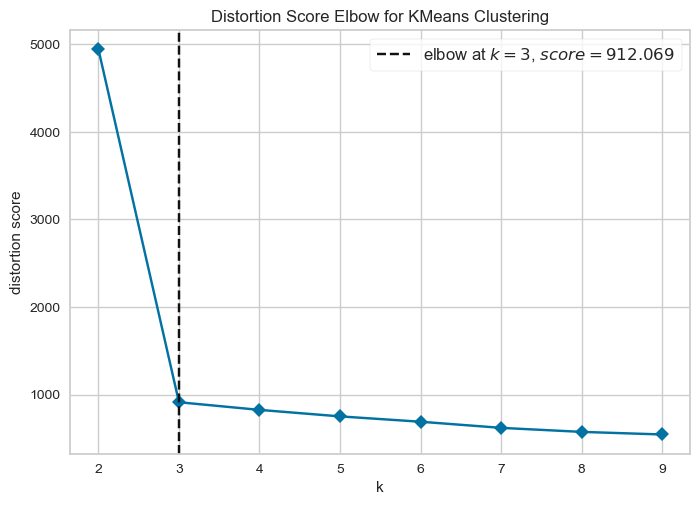

In [23]:
# Visualización del codo

model = KMeans(n_init=10, max_iter=300, random_state=42)

visualizer = KElbowVisualizer(
    model,
    k=(2,10),            # rango de K
    metric='distortion', # usa inercia/distortion
    timings=False
)

visualizer.fit(X)
visualizer.show()
plt.show()

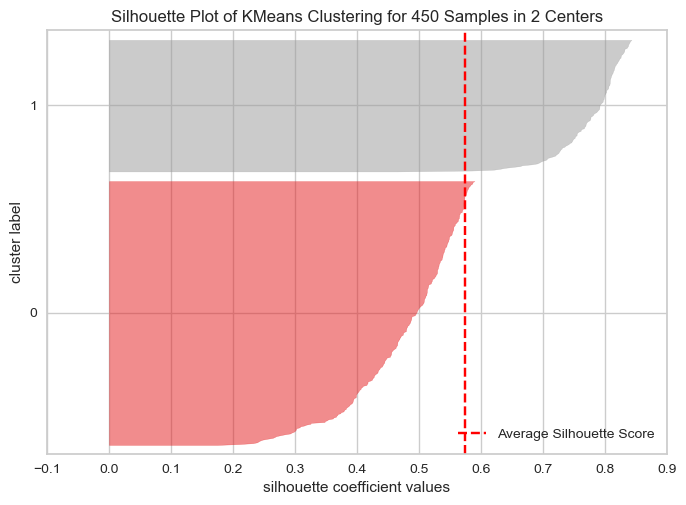

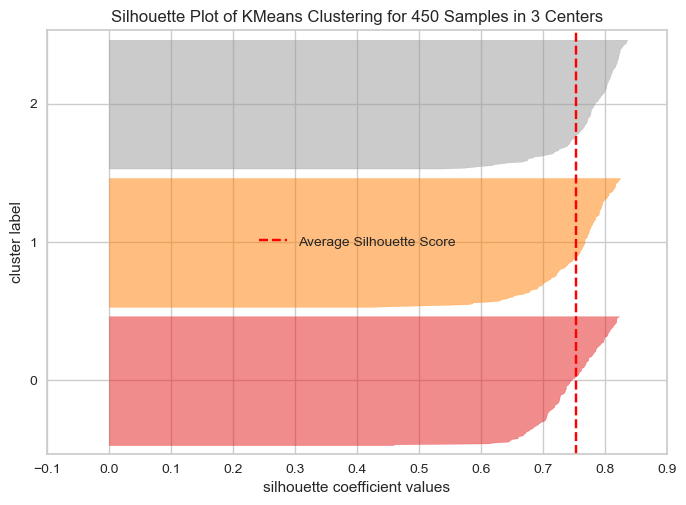

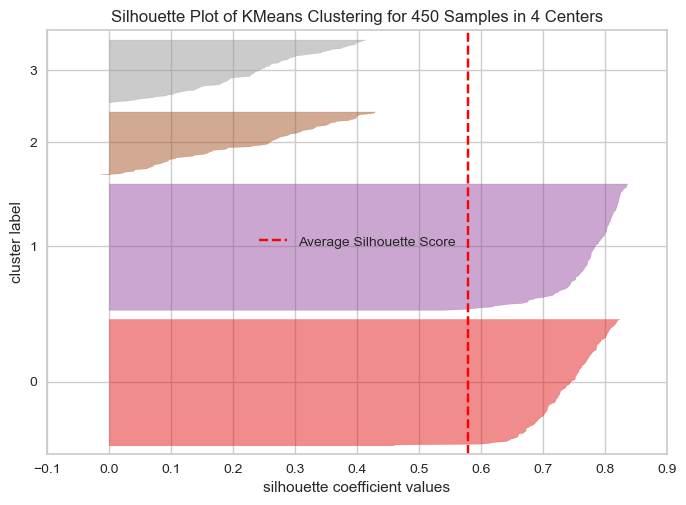

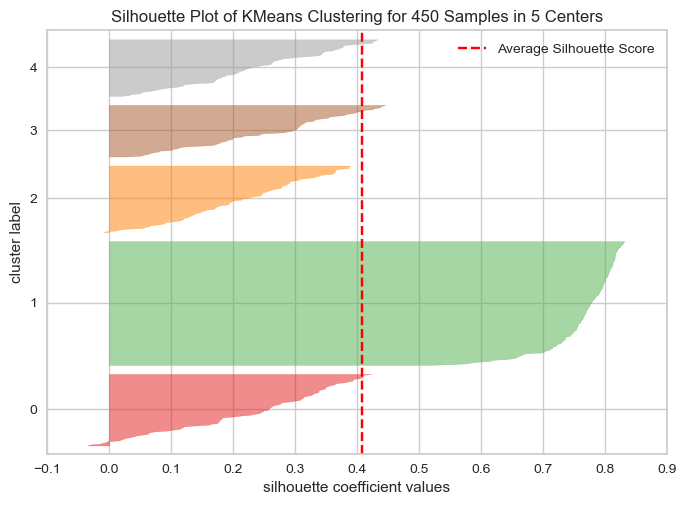

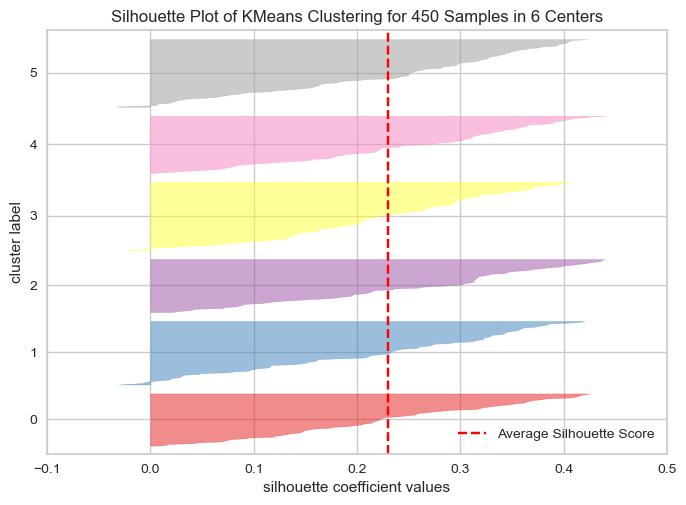

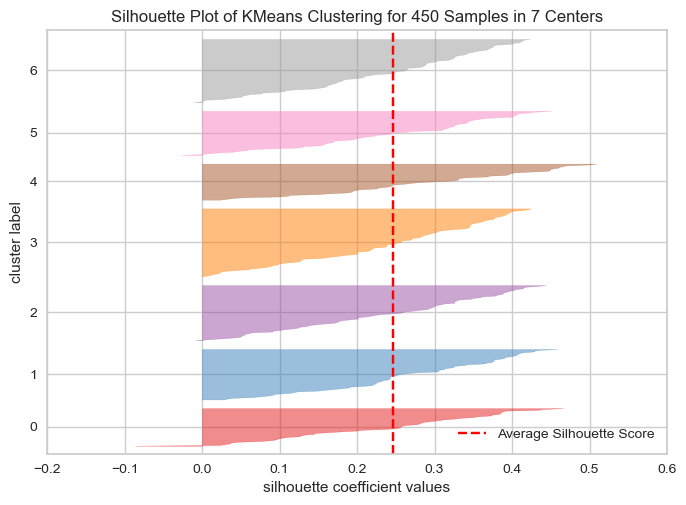

In [28]:
# Visualización del coeficiente de la silueta

k_optimo_list = [2,3,4,5,6,7] # podemos iterar y ver varias gráficas

for k_optimo in k_optimo_list:
    km3 = KMeans(n_clusters=k_optimo, n_init=10, max_iter=300, random_state=42)
    
    viz = SilhouetteVisualizer(km3)
    viz.fit(X)
    viz.show()
    
    plt.show()

# Limitaciones de K-Means

- Asume clústers aproximadamente esféricos (usa distancia euclidiana).
- No funciona bien si los clústers tienen formas alargadas o no convexas.
- Es sensible a *outliers*, porque el promedio puede moverse mucho.
- Necesita que especifiquemos $K$ antes de correr.
- Puede atascarse en mínimos locales: diferentes inicializaciones pueden dar soluciones diferentes.

Aun con estas limitaciones, K-Means es extremadamente popular porque es:
- rápido,
- fácil de implementar,
- fácil de interpretar (centroides como "representantes" del grupo),
- útil como paso previo a otros métodos (por ejemplo, para compresión o inicialización de otros modelos).
